<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/DefectNet/DefectSniffer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defect Sniffer: Locating Atomic Defects in Scanning Transmisssion Electron Microscopy Data with a Neural Network

Notebook prepared by Maxim Ziatdinov

Contact e-mail: ziatdinovmax@gmail.com

In this notebook, I will demonstrate how to use a convolutional neural network for locating atomic defects in a scanning transmission electron microscopy movie. Specifically, I will show how to train a model for a pixel-wise prediction of defect locations in the experimental movie featuring decomposition of 2D material under electron beam irradiation using only a single (labeled) experimental image for a training set. The labels (ground truth) for a single image are generated using a Fourier subtraction method which takes advantage of the fact that at the beginning of the movie (specifically, in the first frame) the global periodicity of the lattice is still maintained. Then both experimental image and labels (ground truth) are augmented and the generated batches are fed to a neural network on-the-fly. Once the network is trained, it relies solely on local edge properties for identification of defects and is thus stable toward formation of extended defects, rotations, and fragmentations of the lattice (that is, the situations where Fourier-based methods typically fail). Here we show that a network trained on a single (first) movie frame is capable of locating atomic defects in the remaining movie frames that were not a part of the training set.

## Import/Install modules

In [1]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/pycroscopy/AICrystallographer.git
    !cp -r AICrystallographer/DefectNet/* . 
!sh packages.sh

Cloning into 'AICrystallographer'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1552 (delta 16), reused 7 (delta 5), pack-reused 1521
Receiving objects: 100% (1552/1552), 156.66 MiB | 34.01 MiB/s, done.
Resolving deltas: 100% (840/840), done.
Checking out files: 100% (279/279), done.


Downloading...
From: https://drive.google.com/uc?id=1Zz9iSr5eUsV9wHUzebbdp_Szr6GUiibf
To: /content/WS2stack4_subset.npy
74.4MB [00:00, 132MB/s] 

Checking if PyTorch sees GPU device...
Available GPU devices:
Tesla T4

Installing packages for vizualization of neural networks...
  Running command git clone -q https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-g5yv49qh


Import necessary modules:

In [0]:
# Data manipulation and plotting
import os
import numpy as np
import ffts
from augment import *
import matplotlib
import matplotlib.pyplot as plt
import pydot
from torchviz import make_dot
# Neural networks
import torch
import dcnn
import loss
from utils import *

## Processing single experimental frame

We start with loading the experimental data. Here we will use a subset (70 images/frames) of experimental data on WS$_2$ decomposition under the electron beam irradiation. The data is already in the numpy array format, so we are not going to discuss a translation procedure (in this case, from .dm3 to .npy), which can be easily performed using either [Pycroscopy translators](https://pycroscopy.github.io/pycroscopy/translators.html) or [this notebook](https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/AtomNet/dm3-to-numpy-v2.ipynb) with a quick dm3-to-numpy convertor (if your data is in .dm3 format).

Notice that here you can [upload your own data](https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/Tutorials/ColabNotebooks_BasicOperations.ipynb#scrollTo=BkkrjXN8x_Vq) and apply the methods described below to your data (you will probably need to adjust parameters of FFT substaction method and data augmentation procedure for your data).

In [0]:
imgdata = np.load('exp_data/WS2stack4_subset.npy')

Load and view a single frame:

In [0]:
imgsrc = imgdata[0]

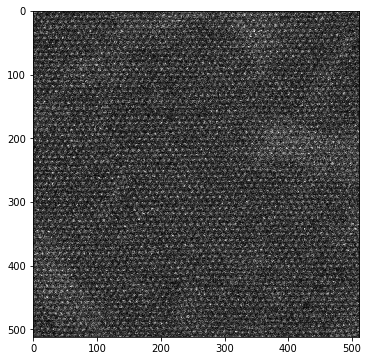

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(imgsrc, cmap = 'gray')

Our goal is to identify atomic defects in this frame using our general (domain) knowledge about materials and  crystallography. We perform FFT subtraction in a similar manner as described in Nanotechnology 24, 415707 (2013) relying on the fact that in the beginning of the movie a global periodicity is still maintained. We need to create a mask and apply it as a high-pass filter in the frequency domain. For this, we need to introduce a human-defined parameter: 1/ratio of radius of the mask to the image size. Notice that for larger defect structures one can also use RAAFT method for constructing a mask ([see this notebook](https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/DefectNet/RAAFTingForFunAndProfit.ipynb)).

In [0]:
maskratio = 10
F2, F3 = ffts.FFTmask(imgsrc, maskratio)

Plot Global FFT and global FFT with high-pass filter applied:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


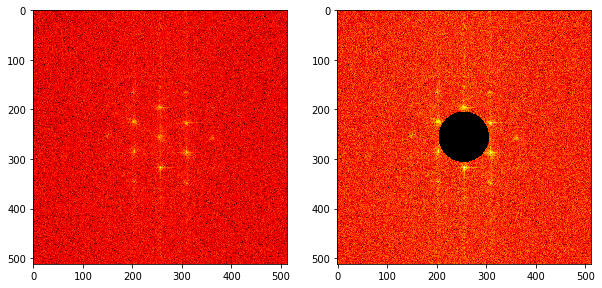

In [0]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(np.abs(np.log(F2)), cmap='hot')
masked_array = np.ma.array (np.abs(np.log(F3)), mask=np.isnan(np.abs(np.log(F3))))
cm = matplotlib.cm.hot
cm.set_bad('black',1.)
ax2.imshow(masked_array, cm)

Now we reconstruct the real space image from filtered FFT image and subtract it from the original to identify locations with broken symmetry: 

In [0]:
diff = ffts.FFTsub(imgsrc, F3)

We need to threshold the resulting difference image to create a map for the defect locations, which will serve as labels for pixels in our training set. We need to define 2 thresholds: low for low intensity defects and high for high-intensity. Since we normalized the difference image they are both in [0;1) range. We can use histogram of intensities to inform our choice:

In [0]:
diffall = diff.reshape(diff.shape[0] * diff.shape[1])

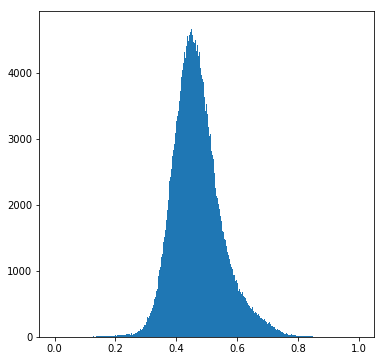

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(diffall, bins='auto');

We can also compute statistics for the intensity distributions, but those should be taken as guidance and confirmed by visual inspection as they can vary from image to image.

In [0]:
print('Defining cutoff as 2 std, low threshold:', np.mean(diffall) - 2* np.std(diffall), 
      ' high thresold: ', np.mean(diffall) + 2* np.std(diffall))
print('Defining cutoff as 3 std, low threshold:', np.mean(diffall) - 3* np.std(diffall), 
      ' high thresold: ', np.mean(diffall) + 3* np.std(diffall))

Defining cutoff as 2 std, low threshold: 0.3071303218603134  high thresold:  0.6319908648729324
Defining cutoff as 3 std, low threshold: 0.22591518610715866  high thresold:  0.7132060006260872


Define thresholds:

In [0]:
threshL = 0.3
threshH = 0.75
threshI = ffts.threshImg(diff, threshL, threshH)

Finally, plot the defect location map overlaid with the experimental movie frame:

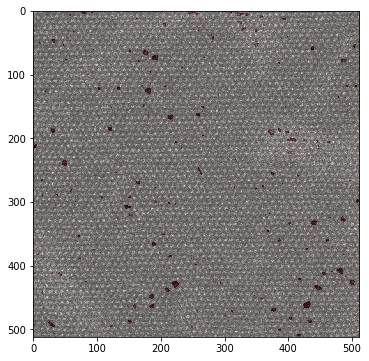

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(imgsrc, cmap = 'gray')
ax.imshow(threshI, cmap='Reds', alpha=0.3)

This will be our ground truth (to which we also refer here as mask and labels):

In [0]:
mask = threshI.astype(int)

## Data augmentation

We next define parameters for data augmentation procedure, including size of each produced image, noise parameters (as a dictionary) and zoom-in range.

**Note:** The image-groundtruth pair(s) can be produced by different methods (including manual data labeling) depending on the problem at hand. The augmentation procedure shown below will work regardlessly (as long as you provide an image-ground truth pair in the same format as here)

In [0]:
# Define parameters of image croppping
window_size = (256, 256)
step_size = 64
batch_size = 32
n_channels = 1
# Define image dostortion/noise parameters
zoom = (224, 256+1, 8)
resize = (256-32, 256+32+1, 8)
# Noise parameters are defined as dictionary
noise_dict = {}
noise_dict['poisson'] = (100,120)
noise_dict['gauss'] = (0, 100)
noise_dict['blur'] = (0,2)
noise_dict['contrast'] = (8,12)
noise_dict['salt and pepper'] = (0,5)

We can now perform a data augmentation procedure. First, we produce a stack of cropped images by sliding a window of size 256x256 across the original image with a step of 24 and extracting the image portion that ovelpaps with the window at each step. Then we apply various transformations/distortions (such as gaussian noise and scan scars) to each image in the stack.

Note: If you don't want a certain transformation to be applied, just remove it from data_transform initialization.

In [0]:
# Generate a batch of cropped image-mask pairs
imcrop = cropper(imgsrc, mask, window_size, step_size, batch_size)
images, labels = imcrop.imgen()
# Apply specific transformations to each image in the batch
imaug = data_transform(
    batch_size, window_size[0], window_size[1], n_channels,
    noise = noise_dict, zoom = zoom, flip = True,
    resize = resize)
images, labels = imaug.transform(images, labels)

Plot some of the augmented images with the corresponding ground truth:

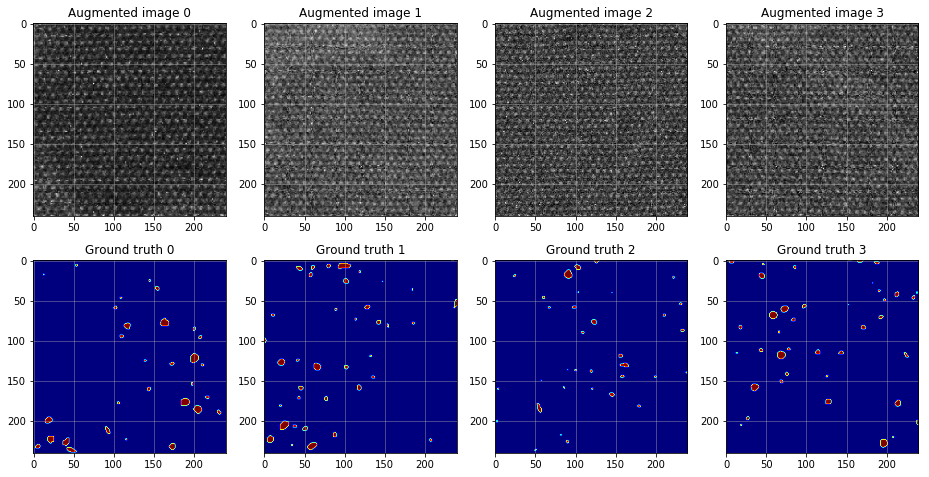

In [0]:
n = 4

n = n + 1
fig = plt.figure( figsize=(20, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap = 'gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1,0,:,:], cmap = 'jet', Interpolation = 'Gaussian')
    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha = 0.5)

## Deep learning models

Now we are ready to create/initialize our deep learning model. We tested two models. The first one is a fully convolutional neural network with the encoder-decoder type of architecture. The encoder part starts with a single convolutional layer followed by a max-pooling layer. Then there are 2 back-to-back convolutional layers and a max-pooling layer that follows them. The decoder part consists of the same convolutional layers but in the reversed order and a bilinear upsampling instead of max-pooling. All the convolutional layers are activated by a leaky ReLU function. Here we can visualize it:

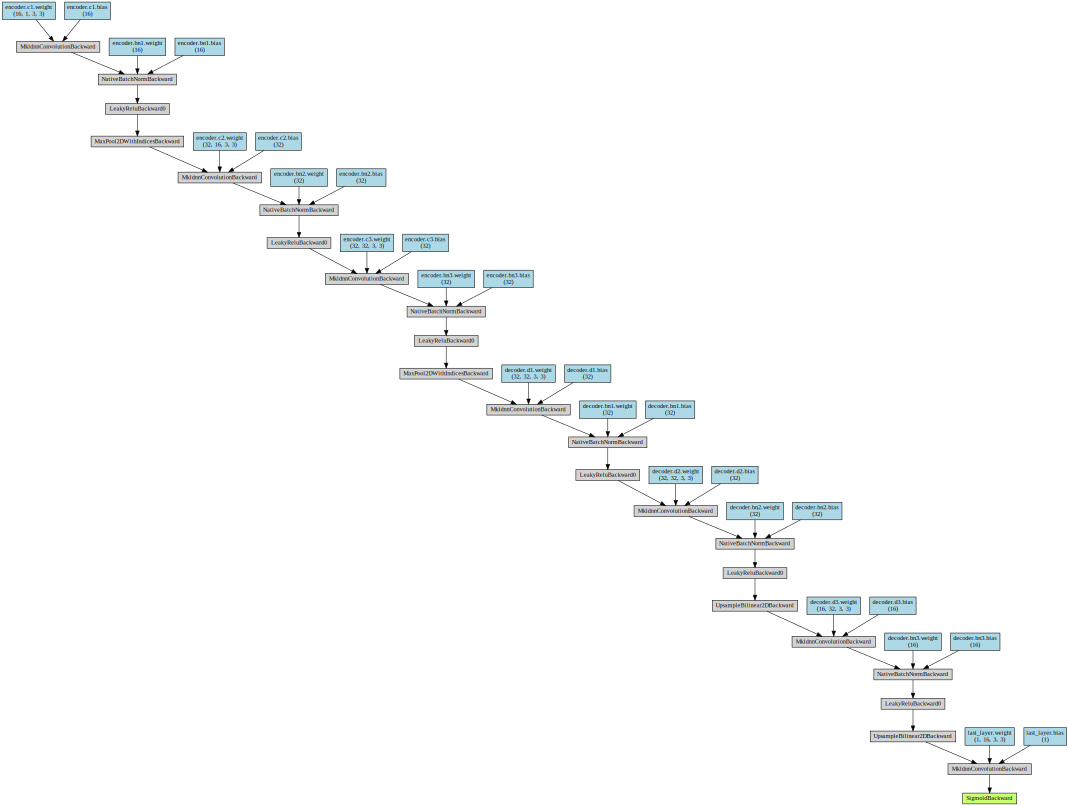

In [0]:
model = dcnn.Sniffer()
x = torch.randn(1, 1, 256, 256).requires_grad_(False)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

Another model is based on the idea of residual blocks. We start with a single convolutional layer followed by max-pooling operation. Then we have $n$ convolutional residual blocks (here $n$=2). Finally we perform upsampling to return to the size of the input data and pass the feature maps through the final convolutional layer, which has the same parameters as the first layer. Here again all the convolutional layers are activated by a leaky ReLU function. Below is a visuzalization of the second model:

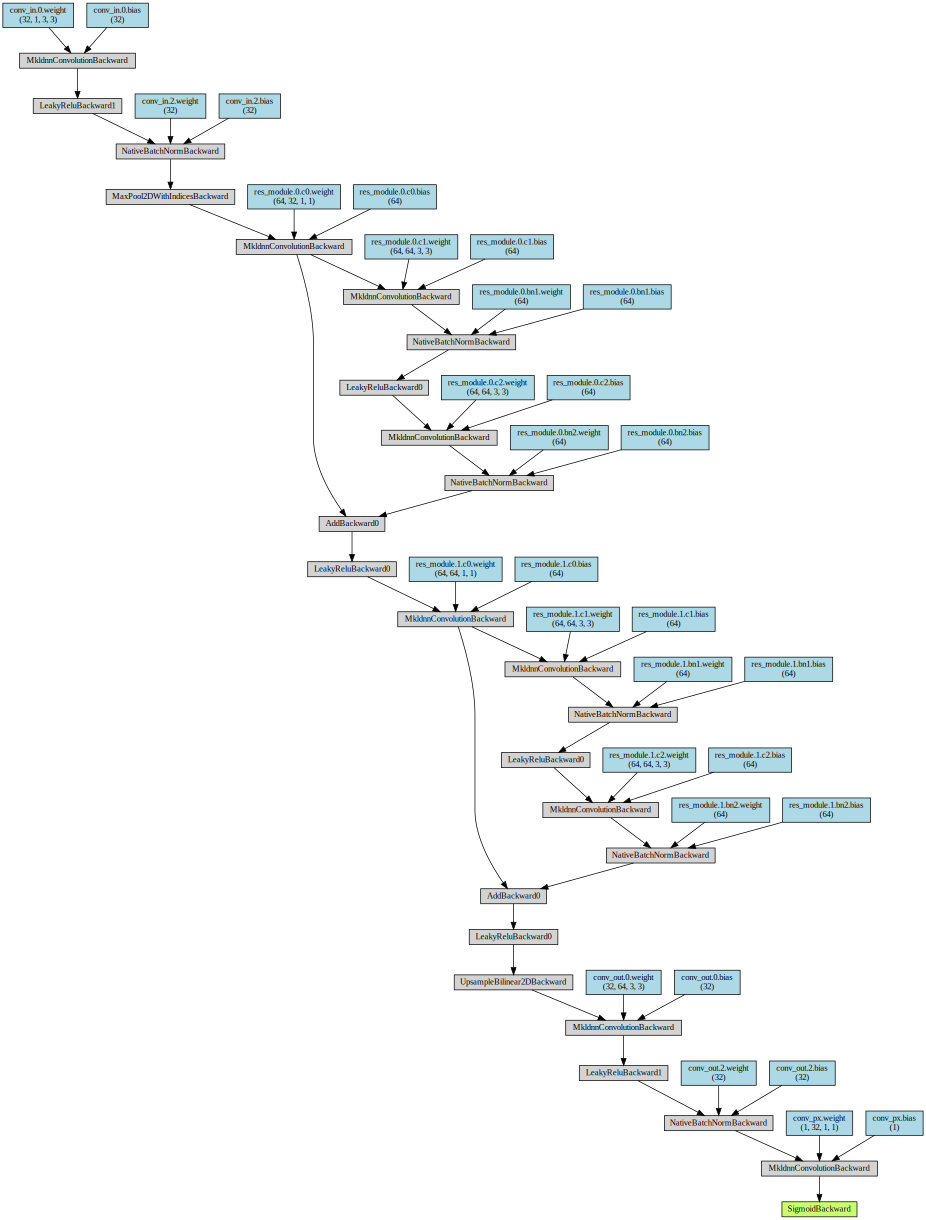

In [0]:
model = dcnn.ResSniffer(res_depth=2)
x = torch.randn(1, 1, 256, 256).requires_grad_(False)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

Here, we are going to use the first model. After we initiate our model, we  move it to a Colab's GPU device, define a loss function and an optimizer. We are going to use a so-called focal loss (see arxiv:1708.02002) due to a large "class imbalance" between lattice (background) and defects.

In [0]:
#initiate model and move it to GPU
model = dcnn.Sniffer(input_channels=32, lrelu_a=0.03, with_logits=True)
model.cuda()
# specify loss function.
criterion = loss.focal(alpha = .25, gamma = 1.5, with_logits=True)
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

## Model traning

Finally we can train our model. We will be generating training data on-the-fly using augmentaton parameters determined earlier.

In [0]:
epochs = 3000 # Number of epochs (here 1 epoch == 1 batch)
save_weights = 100 # save weights every n-th epoch.
print_loss = 50 # print loss every m-th epoch.
# Initialize image cropper
imcrop = cropper(imgsrc, mask, window_size, step_size, batch_size)
# Initialize image augmentor
imaug = data_transform(
    batch_size, window_size[0], window_size[1], n_channels,
    noise = noise_dict, zoom = zoom, resize = resize,
    flip = True, rotate90 = True)
# Start training
train_losses = []
for e in range(epochs):  
    model.train()
    running_loss = 0
    # Generate batch of images with corresponding ground truth
    images, labels = imcrop.imgen()
    images, labels = imaug.transform(images, labels)
    # Transform images and ground truth to torch tensors and move to GPU
    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).float()
    images, labels = images.cuda(), labels.cuda() 
    # Forward --> Backward --> Optimize
    optimizer.zero_grad() 
    prob = model.forward(images)
    loss = criterion(prob, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    train_losses.append(running_loss)
    # Print statistics
    if e == 0 or (e+1)%print_loss == 0:
        print('Epoch', str(e+1) + 4*'.', 'Training loss:',
              str(np.around((running_loss), decimals=8)))
    # Save model weights
    if (e+1)%save_weights == 0:
        torch.save(model.state_dict(), 
                   'saved_models/defect_sniffer-epoch-{}'.format(e+1)+'.pt')
# Save final weights
torch.save(model.state_dict(), 'saved_models/defect_sniffer.pt')

Epoch 1.... Training loss: 0.05978097
Epoch 50.... Training loss: 0.00128099
Epoch 100.... Training loss: 0.00051557
Epoch 150.... Training loss: 0.00037543
Epoch 200.... Training loss: 0.00026612
Epoch 250.... Training loss: 0.00023552
Epoch 300.... Training loss: 0.00015807
Epoch 350.... Training loss: 0.00014054
Epoch 400.... Training loss: 0.00012446
Epoch 450.... Training loss: 8.7e-05
Epoch 500.... Training loss: 0.00011091
Epoch 550.... Training loss: 9.433e-05
Epoch 600.... Training loss: 6.638e-05
Epoch 650.... Training loss: 8.193e-05
Epoch 700.... Training loss: 7.865e-05
Epoch 750.... Training loss: 6.801e-05
Epoch 800.... Training loss: 5.505e-05
Epoch 850.... Training loss: 7.152e-05
Epoch 900.... Training loss: 4.725e-05
Epoch 950.... Training loss: 6.355e-05
Epoch 1000.... Training loss: 6.049e-05
Epoch 1050.... Training loss: 4.425e-05
Epoch 1100.... Training loss: 4.052e-05
Epoch 1150.... Training loss: 5.874e-05
Epoch 1200.... Training loss: 5.593e-05
Epoch 1250.... 

We can plot a training loss:

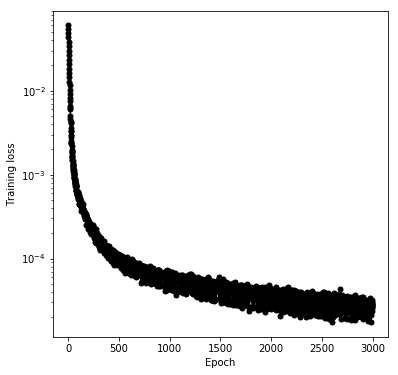

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(train_losses, '-o', color='black', markersize=5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training loss')
ax.set_yscale('log')

## Prediction on new data

Now let's see how it works on the remaining frames of the movie (the ones that were not used for generation of training data, that is, the network has never seen them before). We load best/final weights back into our model:

In [0]:
weights_path = 'saved_models/defect_sniffer.pt'
model_ = dcnn.Sniffer(input_channels=32, with_logits=True)
model = dcnn.load_torchmodel(weights_path, model_)

Here, we determine positions of defects for three selected frames (feel free to change frames indices in the list)

Frame 10


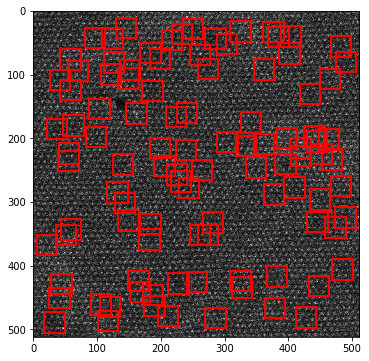

Frame 40


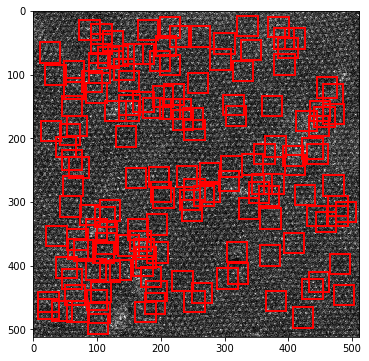

Frame 70


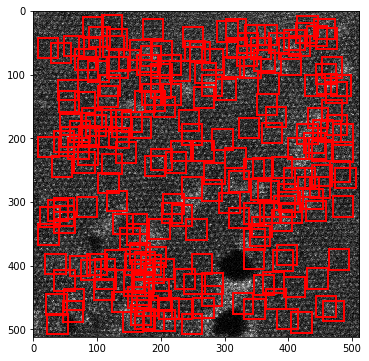

In [0]:
klist = [10, 40, 70]
for k in klist:
    print('Frame {}'.format(k))
    defcoord = inference(imgdata[k], model, thresh=0.1, thresh_blobs=250)
    draw_boxes(imgdata[k], defcoord)

As one can see, we were able to detect a majority of defects in the movie frames that were not a part of the training set (notice that we lowered a threshold to 0.1 since in this case the threshold does not have any particular physical meaning).

We can extract coordinates for all the frames, crop the corresponding subimages of the defects , arrrange them into a image stack and perform basic multivariate statistical analysis to learn about basic defect types in the data.

In [0]:
bbox = 16
all_defcoord = np.empty((0, 2))
frame_id = []
all_defects = np.empty((0, int(bbox*2), int(bbox*2)))
for k, frame in enumerate(imgdata):
    defcoord = inference(frame, model, thresh=0.1, thresh_blobs=250)
    for c in defcoord:
        x0, y0 = int(np.round(c[0])), int(np.round(c[1]))
        def_subimg = frame[x0-bbox:x0+bbox, y0-bbox:y0+bbox]
        all_defects = np.append(all_defects, [def_subimg], axis=0)
        all_defcoord = np.append(all_defcoord, [c], axis=0)
        frame_id.append(k)

Save the extracted coordinates:

In [0]:
mdirectory = 'DefectSnifferOutput'
if not os.path.exists(mdirectory):
    os.makedirs(mdirectory)  

np.save(os.path.join(mdirectory, 'all_defects.npy'), all_defects)
np.save(os.path.join(mdirectory, 'frame_id.npy'), frame_id)
np.save(os.path.join(mdirectory, 'all_defcoord.npy'), all_defcoord)

## Clustering/Unmixing

Import additional modules that we'll need in this section:

In [0]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

"Flatten" the image stack with defects:

In [0]:
n, w, h = all_defects.shape
X_vec = all_defects.reshape(n, w*h)
print(X_vec.shape)

(10335, 1024)


### Estimating number of classes/clusters

We can use a hierarchical clustering dendrogram to estimate a correct number of classes:

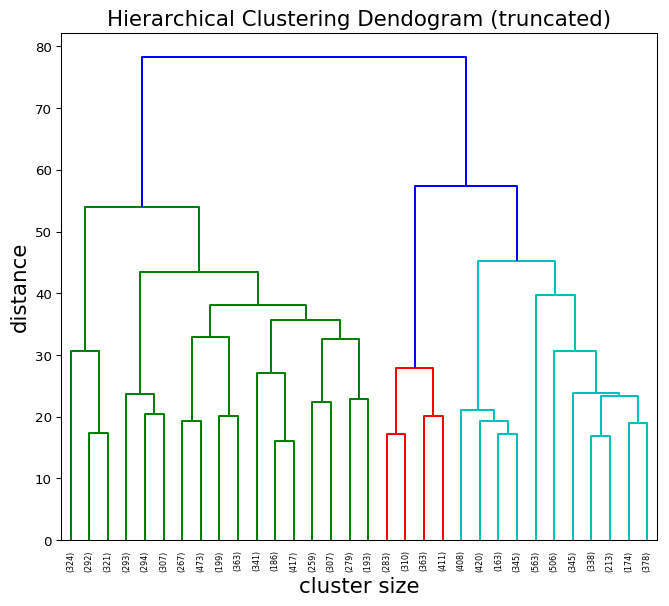

In [0]:
Z = linkage(X_vec, method='ward')
plt.figure(figsize = (8,7), dpi = 96)
dendrogram(Z, truncate_mode='lastp', p=32, leaf_rotation=90.,leaf_font_size=6.,)
plt.title('Hierarchical Clustering Dendogram (truncated)', fontsize=16)
plt.xlabel('cluster size', fontsize=16)
plt.ylabel('distance', fontsize=16)
plt.show()

We can also explore the data variance with PCA:

(0, 50)

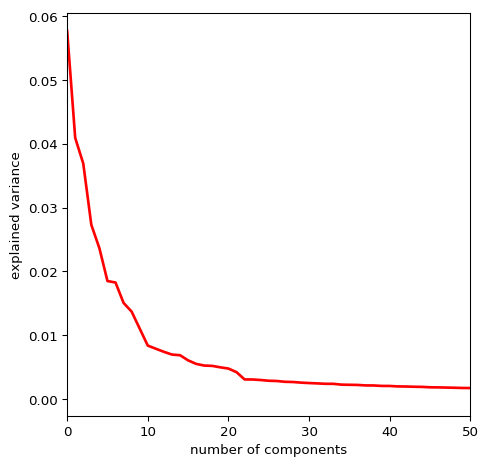

In [0]:
pca = PCA()
pca.fit(X_vec)
plt.figure(1, figsize=(6, 6), dpi = 96)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2, c = 'red')
plt.axis('tight')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xlim(0, 50)

### Clustering/Unmixing

Run k-means clustering or Gaussian mixture model with selected number of components:

In [0]:
nc = 6
classifier = 'GMM'

if classifier == 'GMM':
    clf = mixture.GaussianMixture(n_components=nc, covariance_type='diag', random_state=8000).fit(X_vec)
else:
    clf = KMeans(n_clusters=nc).fit(X_vec)

classes = clf.predict(X_vec) + 1

Plot (and save) the resultant components:

In [0]:
my_colors = ['red', 'blue', 'black', 'green', 'orange', 'magenta', 'yellow', 'navy', 'maroon', 'sandybrown']

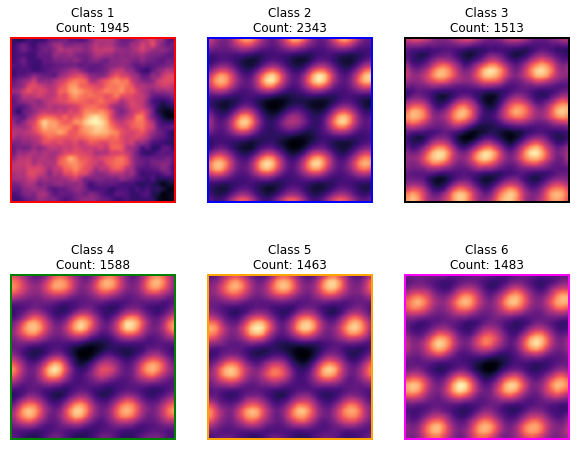

In [0]:
cla = np.ndarray(shape=(np.amax(classes), int(bbox*2), int(bbox*2)))
fig = plt.figure(figsize=(10, 8))

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))

gs1 = gridspec.GridSpec(rows, cols)

for i in range(np.amax(classes)):
    cl = all_defects[classes == i + 1]
    cla[i] = np.mean(cl, axis=0) 
    ax = fig.add_subplot(gs1[i])
    ax.imshow(cla[i], cmap='magma', Interpolation='Gaussian') 
    ax.set_title('Class ' + str(i + 1) + '\nCount: ' + str(len(cl)))
    for spine in ax.spines.values():
            spine.set_edgecolor(my_colors[i])
            spine.set_linewidth(2)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([]) 

fig.savefig(os.path.join(mdirectory, 'DefectClasses.png'))

The unmixing results show a presence of subsitutional impurities with lower (Class 1) and higher (Class 2) atomic Z number, vacancy in one of the sublattices (Class 3) and vacancy in one of the sublattices coupled to a substitutional impurity with lower Z (Class 4-6). Notice that this doesn't take into account that certain classes can be related to each other by material 's lattice discrete rotational symmetry.

We can now plot the evolution of the detected classes in time:

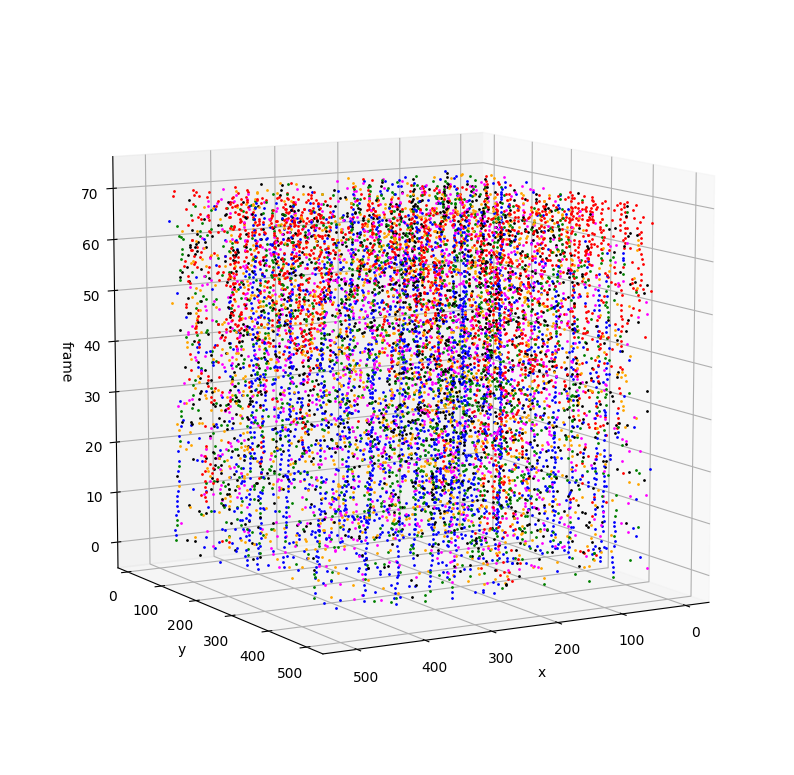

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10), dpi = 100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('frame')

for coord, cla, frame in zip(all_defcoord, classes, frame_id): 
    ax.scatter(coord[0], coord[1], frame, c = my_colors[cla-1], s = 1)

ax.view_init(10, 60)
ax.axis('equal')
ax.auto_scale_xyz([0, imgdata.shape[1]], [0, imgdata.shape[2]], [0, len(imgdata)])
fig.savefig(os.path.join(mdirectory, 'DefectClassesTrajectory.png'))

Download results to local machine (if using Colab)

In [0]:
if not int(nbtype[0]):
    from google.colab import files
    !zip -r output.zip $mdirectory
    files.download('output.zip')

  adding: DefectSnifferOutput/ (stored 0%)
  adding: DefectSnifferOutput/all_defcoord.npy (deflated 49%)
  adding: DefectSnifferOutput/all_defects.npy (deflated 60%)
  adding: DefectSnifferOutput/frame_id.npy (deflated 100%)
  adding: DefectSnifferOutput/DefectClasses.png (deflated 1%)
  adding: DefectSnifferOutput/DefectClassesTrajectory.png (deflated 3%)
